In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import os
from sklearn.metrics import f1_score
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from datetime import datetime
from xgboost import XGBClassifier
import seaborn as sns


C:\Users\omore\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Путь к директории с данными

data_dir = '../00_data/track_1/'
extra_data_dir =  '../00_data/1_track_extra_train/'
sumbit_dir = '../02_submits/'
preprocessed_dir = '../03_preprocessed_data/'

# Метео
mc = pd.read_csv(data_dir + 'meteo_coord.csv')
mld = pd.read_csv(data_dir + 'meteo_1day.csv')
mlm = pd.read_csv(data_dir + 'meteo_1month.csv')
#m3h = pd.read_csv(data_dir + 'meteo_3hours.csv')
rhv = pd.read_csv(data_dir + 'reference_horiz_visib.csv')
main_df = pd.read_csv(data_dir + 'train.csv')
test = pd.read_csv(data_dir + 'test.csv')

# Гидро
hc = pd.read_csv(data_dir + 'hydro_coord.csv')
hld = pd.read_csv(data_dir + 'hydro_1day.csv',
                   parse_dates=['date'])
h1d_extra = pd.read_csv(extra_data_dir + 'hydro_1day.csv',
                   parse_dates=['date'])

hld = pd.concat([hld, h1d_extra])
rwc = pd.read_csv(data_dir + 'reference_water_codes.csv')
#os.listdir(data_dir)
all_pressure_data_level_1000 = pd.read_pickle(preprocessed_dir + 'all_pressure_data_level_1000.pkl')

In [3]:
# Проранжировать станции по течению реки
# 3019 Киренск
# 3027 Витим
# 3028 Пелендуй
# 3029 КРЕСТОВСКОЕ 
# 3030 ЛЕНСК 
# 3035 ОЛЕКМИНСК 
# 3041 ПОКРОВСК 
# 3045 ЯКУТСК 
# 3230 БАТАМАЙ 
# 3050 САНГАРЫ 

station_id_ordered = [3019, 3027, 3028, 3029, 3030, 3035, 3041, 3045,  3230, 3050]
station_id_rank = range(0, len(station_id_ordered))
station_id_rank = dict(zip(station_id_ordered, station_id_rank))
previous_station = [-1] + station_id_ordered[:-1]
previous_station = dict(zip(station_id_ordered, previous_station))
station_width = [412, 538, 654, 832, 1000, 2070, 4100, 7390, 9000, 5370]
station_width =  dict(zip(station_id_ordered, station_width))

In [4]:
all_pressure_data_level_1000['station_id'] = all_pressure_data_level_1000['station_id'].astype(int)
all_pressure_data_level_1000 = all_pressure_data_level_1000.reset_index()
all_pressure_data_level_1000 = all_pressure_data_level_1000.drop(['lat', 'lon'], axis = 1)
all_pressure_data_level_1000['date']= all_pressure_data_level_1000['time'].dt.date.astype(str)
all_pressure_data_level_1000 = all_pressure_data_level_1000[all_pressure_data_level_1000['station_id'].isin(station_id_ordered)]

In [5]:
all_pressure_data_level_1000[(all_pressure_data_level_1000['station_id'] == 3019) &
(all_pressure_data_level_1000['date'] == '2015-12-01')]

,time,air,station_id,hgt,uwnd,vwnd,shum,rhum,omega,date
425016,2015-12-01 00:00:00,267.599976,3019,141.0,4.000000,0.100002,0.00251,100.0,0.025,2015-12-01
425017,2015-12-01 06:00:00,266.399994,3019,168.0,5.300002,0.800003,0.00223,97.0,-0.018,2015-12-01
425018,2015-12-01 12:00:00,264.200012,3019,192.0,3.200000,0.600003,0.00194,100.0,0.033,2015-12-01
425019,2015-12-01 18:00:00,260.500000,3019,234.0,3.000000,-0.699998,0.00140,97.0,-0.015,2015-12-01


In [6]:
# calculate_height_difference
# distance_from_source - расстояние от истока
# z_null - высотная отметка нуля графика на гидропосте
def calculate_height_difference(dataframe_with_stations):
    dataframe_with_stations=dataframe_with_stations.sort_values(by = 'distance_from_source')
    dataframe_with_stations['height_difference'] = dataframe_with_stations['z_null'] - dataframe_with_stations['z_null'].shift(1) 
    dataframe_with_stations['distance_to_previous'] = dataframe_with_stations['distance_from_source'] - dataframe_with_stations['distance_from_source'].shift(1)
    dataframe_with_stations['height_diff_by_dist'] = dataframe_with_stations['height_difference']/dataframe_with_stations['distance_to_previous']
    dataframe_with_stations.fillna(0, inplace = True)
    return dataframe_with_stations

# Гидрологические данные

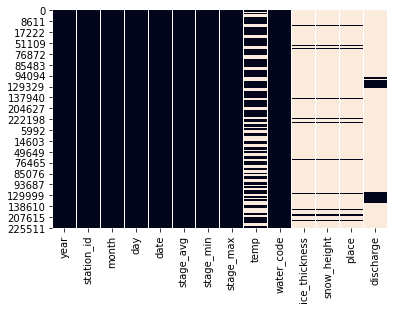

In [7]:
hld = hld[hld['station_id'].isin(station_id_ordered)]

sns.heatmap(hld.isnull(), cbar=False)

В летние месяцы заполнить толщину льда и высоту снена нулем. В остальные дни сделать интерполяцию по дате для каждой станции.

In [8]:
months_with_ice = hld.loc[ hld['ice_thickness'] > 0, 'month'].unique()
hld.loc[~(hld['month'].isin(months_with_ice)), 'ice_thickness'] = 0
hld.loc[~(hld['month'].isin(months_with_ice)), 'snow_height'] = 0
hld = hld.sort_values(['station_id', 'year', 'day'])
hld[['ice_thickness', 'snow_height']] = hld.\
    groupby('station_id')['ice_thickness',  'snow_height'].\
    apply(lambda group: group.interpolate(method='index'))

C:\Users\omore\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [9]:
hld[['ice_thickness', 'snow_height']] = hld[['ice_thickness', 'snow_height']].fillna(method='bfill', limit=20)

Пропущенную температуру воды заполним нулем

In [10]:
hld['temp'] = hld['temp'].fillna(0)

Place заполнить нулем в летние месяцы и паддингом назад в остальные

In [11]:
hld.loc[~(hld['month'].isin(months_with_ice)), 'place'] = 0
hld['place'] = hld['place'].fillna(method='bfill', limit=20)

In [12]:
hld = hld.drop(['discharge'], axis = 1)

# Метеорологические данные

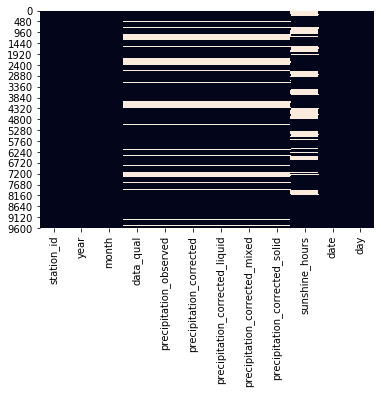

In [13]:
mlm = mlm.sort_values(['station_id', 'year', 'month'])

sns.heatmap(mlm.isnull(), cbar=False)

In [14]:
mlm = mlm.sort_values(['station_id', 'year', 'month'])
num_cols = ['precipitation_observed',
            'precipitation_corrected', 
            'precipitation_corrected_liquid',
           'precipitation_corrected_mixed',
           'precipitation_corrected_solid',
           'sunshine_hours']
mlm[num_cols] = mlm[num_cols + ['station_id']].groupby('station_id').\
    apply(lambda group: group.interpolate(method='index')).drop('station_id', axis = 1)


In [15]:
mlm[num_cols + ['station_id']].groupby('station_id').\
    apply(lambda group: group.interpolate(method='index'))

,precipitation_observed,precipitation_corrected,precipitation_corrected_liquid,precipitation_corrected_mixed,precipitation_corrected_solid,sunshine_hours,station_id
0,3.8,5.7,0.0,0.0,5.7,NaN,24538
1,3.6,5.2,0.0,0.0,5.2,NaN,24538
2,21.3,23.6,23.6,0.0,0.0,NaN,24538
3,20.6,20.7,20.7,0.0,0.0,NaN,24538
4,27.5,27.2,25.3,1.1,0.8,NaN,24538
...,...,...,...,...,...,...,...
10055,25.2,23.7,0.0,0.0,23.7,NaN,31137
10056,3.1,2.6,0.0,0.0,2.6,NaN,31137
10057,13.8,14.1,0.0,0.0,14.1,NaN,31137
10058,18.3,17.5,0.0,0.0,17.5,NaN,31137


In [16]:
mlm = mlm.fillna(method='bfill', limit=20)


In [17]:
#mld = mld.sort_values(['station_id', 'year', 'month'])

#sns.heatmap(mld.isnull(), cbar=False)

In [18]:
# sns.heatmap(mlm.isnull(), cbar=False)

In [19]:
# sns.heatmap(m3h.isnull(), cbar=False)

In [20]:
# соединим train и test, чтобы фичи генерировались и на тесте тоже
main_df = pd.concat([main_df, test])
main_df['is_test'] = main_df['ice_jam'].isnull()
main_df['station_rank'] = main_df['station_id']
main_df = main_df.replace({"station_rank": station_id_rank})
main_df['station_width'] = main_df['station_id']
main_df = main_df.replace({'station_width': station_width})
main_df['previous_station'] = main_df['station_id']
main_df = main_df.replace({"previous_station": previous_station})
main_df['previous_station'] = main_df['previous_station'].astype(int)

### Затор в прошлом году в тот же день

In [21]:
main_df['previous_year'] = main_df['year'] - 1
X = main_df.merge(main_df[['year', 'day', 'station_id','ice_jam']], 
              how = 'left', 
              left_on = ['previous_year', 'day', 'station_id'],
              right_on = ['year', 'day', 'station_id']
             ).drop([
                     'year_y'], axis =1
                   ).rename(columns={'year_x':'year', 
                 'ice_jam_x':'ice_jam',
                 'ice_jam_y':'ice_jam_same_day_last_year',             
                 'previous_station_x':'previous_station',
                 'station_rank_x': 'station_rank',
                 'previous_year_x': 'previous_year',
                  'is_test_x':'is_test'                   
                                     
                              })
main_df = main_df.drop('previous_year', axis = 1)
X.head()

,year,station_id,day,ice_jam,is_test,station_rank,station_width,previous_station,previous_year,ice_jam_same_day_last_year
0,2000,3019,1,0.0,False,0,412,-1,1999,0.0
1,2000,3019,2,0.0,False,0,412,-1,1999,0.0
2,2000,3019,3,0.0,False,0,412,-1,1999,0.0
3,2000,3019,4,0.0,False,0,412,-1,1999,0.0
4,2000,3019,5,0.0,False,0,412,-1,1999,0.0


### Затор в прошлом году в тот же день на предыдущей станции

In [22]:
X = X.merge(main_df[['year', 'day', 'station_id', 'ice_jam']], 
              how = 'left', 
              left_on = ['previous_year', 'day', 'previous_station'],
              right_on = ['year', 'day', 'station_id']
             ).drop(['year_y', 'station_id_y'], axis =1
                   )\
.rename(columns={'year_x':'year',
                 'station_id_x':'station_id',
                 'ice_jam_x':'ice_jam',
                 'ice_jam_y':'ice_jam_same_day_last_year_prev_stat'           
                              })

In [23]:
X = X.fillna(0)


### Затор в позапрошлом году в тот же день

In [24]:
X['preprevious_year'] = X['year'] - 2
X = X.merge(main_df[['year', 'day', 'station_id', 'ice_jam']],
              how = 'left', 
              left_on = ['preprevious_year', 'day', 'station_id'],
              right_on = ['year', 'day', 'station_id']
             ).drop(['preprevious_year', 'year_y'], axis =1
                   ).rename(columns={'year_x':'year', 
                 'ice_jam_x':'ice_jam',
                 'ice_jam_y':'ice_jam_same_day_prelast_year',
                              })
X.head()
X.shape

(15183, 12)

### Индикатор - есть ли данные по заторам за прошлый год

In [25]:
X['is_last_year_missing'] = X['ice_jam_same_day_last_year'].isnull()
X['is_prelast_year_missing'] = X['ice_jam_same_day_prelast_year'].isnull()
X = X.fillna(0)
X.shape

(15183, 14)

### Количество заторов в прошлом году

In [26]:
X[['n_jams_last_year','n_jams_prelast_year']] = \
    X.groupby(['year', 'station_id'])[['ice_jam_same_day_last_year', 'ice_jam_same_day_prelast_year']]\
    .transform('sum')
X.shape

(15183, 16)

### Количество заторов в прошлом году на предыдущей станции

In [27]:
X[['n_jams_last_year_prev_station']] = \
    X.groupby(['year', 'station_id'])[ 'ice_jam_same_day_last_year_prev_stat']\
    .transform('sum')


## Количество заторов в прошлом по всем годам

In [28]:
ice_jams_per_year = X.groupby(['year', 'station_id'])['ice_jam'].sum().reset_index().drop_duplicates()
ice_jams_per_year['n_jams_past'] = ice_jams_per_year.sort_values(by = 'year').\
    groupby(['station_id'])['ice_jam'].cumsum()
ice_jams_per_year['n_jams_past'] = ice_jams_per_year['n_jams_past'] - ice_jams_per_year['ice_jam']
ice_jams_per_year = ice_jams_per_year.drop('ice_jam', axis = 1)
X = X.merge(ice_jams_per_year, how = 'left', on = ['year', 'station_id'])
X.shape

(15183, 18)

In [29]:
X = X.merge(ice_jams_per_year, how = 'left', 
          left_on = ['year', 'previous_station'],
         right_on = ['year', 'station_id'])\
        .rename(columns={'n_jams_past_y':'n_jams_past_prev_stat',
                         'station_id_x':'station_id',
                         'n_jams_past_x':'n_jams_past'
                        })\
    .drop('station_id_y', axis = 1)
X.shape

(15183, 19)

In [30]:
# n_same_days_before: how many days are available in the past for a given date
X['n_same_days_before'] = X[['year', 'day', 'station_id']] \
    .sort_values(by = ['year', 'day']) \
    .groupby(['station_id', 'day']) \
    .cumcount()
X['n_ice_jams_same_days_before'] = X[['year', 'day', 'station_id', 'ice_jam']] \
    .sort_values(by = ['year', 'day']) \
    .groupby(['station_id', 'day']) \
    ['ice_jam']\
    .cumsum()
X['n_ice_jams_same_days_before'] = X['n_ice_jams_same_days_before'] - X['ice_jam']
X['n_ice_jams_same_days_before_ratio'] = X['n_ice_jams_same_days_before']/X['n_same_days_before']
X = X.fillna(0)

## Разбиение по годам

In [31]:
# Суммарное количество заторов в году
jams_by_year = main_df.groupby('year').sum()['ice_jam'].to_frame().reset_index()
jams_by_year['ice_jam'].describe()

count    35.000000
mean      3.942857
std       4.014260
min       0.000000
25%       0.000000
50%       3.000000
75%       6.000000
max      16.000000
Name: ice_jam, dtype: float64

In [32]:
# Разделим на бины по квартилям
bins = [-1, 3, 5, 8, 16]
jams_by_year['ice_jam_bins'] = pd.cut(jams_by_year['ice_jam'], bins)
X_length = jams_by_year[['year', 'ice_jam']]
y_length = jams_by_year['ice_jam_bins']
y_length.value_counts()

(-1, 3]    18
(3, 5]      7
(5, 8]      6
(8, 16]     4
Name: ice_jam_bins, dtype: int64

In [33]:
# Разделим годы на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X_length, 
                                                    y_length, 
                                                    test_size=0.3,  
                                                    stratify=y_length, 
                                                    random_state=42)

### Feature description

**is_test**:  if is_test = 1 then the row belongs to the test dataset \
**ice_jam_same_day_last_year**: 1 if there were and ice jam on the same day last year \
**ice_jam_same_day_prelast_year**: 1 if there were and ice jam on the same day 2 years ago \
**is_last_year_missing**: 1 is the same day is missing last year \
**is_prelast_year_missing**: 1 is the same day is missing 2 years ago \
**n_jams_last_year**: number of jams last year at the station \
**n_jams_past**: number of jams in the past available data at the station \
**n_same_days_before**: number of same days available in the past \
**n_ice_jams_same_days_before**: number of ice jams ob the same day in the past \
**n_ice_jams_same_days_before_ratio**: n_ice_jams_same_days_before/n_ice_jams_same_days_before

### Соберем фичи из гидроданных

<div class="alert alert-block alert-warning">
Мы не можем использовать данные из будущего: всё, что происходит после заторного периода, относится уже к следующему году.
</div>

In [34]:
# Внесем не темпоральные данные
X = pd.merge(X, hc[['station_id', 
                                'distance_from_source', 
                                'drainage_area', 
                                'z_null']], on='station_id', how='left')

# Возьмем также данные из ежедневных наблюдений
hld.head(1)

,year,station_id,month,day,date,stage_avg,stage_min,stage_max,temp,water_code,ice_thickness,snow_height,place
4864,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0


In [35]:
# добавим реанализ к гидро данным
hld['date']= hld['date'].astype(str)
hld = hld.merge(all_pressure_data_level_1000, on=['station_id', 'date'], how='left')
hld.head()

,year,station_id,month,day,date,stage_avg,stage_min,stage_max,temp,water_code,ice_thickness,snow_height,place,time,air,hgt,uwnd,vwnd,shum,rhum,omega
0,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,1985-01-01 00:00:00,256.500000,226.0,0.100006,1.600006,0.00098,94.000015,0.054998
1,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,1985-01-01 06:00:00,255.400009,230.0,1.400009,3.500015,0.00096,100.000015,0.066998
2,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,1985-01-01 12:00:00,257.000000,246.0,-1.099991,3.400009,0.00109,100.000015,0.036999
3,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,1985-01-01 18:00:00,258.799988,258.0,-0.199997,2.300003,0.00121,96.000015,0.007998
4,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,1985-01-01 00:00:00,256.500000,226.0,0.100006,1.600006,0.00098,94.000015,0.054998


In [36]:
all_pressure_data_level_1000

,time,air,station_id,hgt,uwnd,vwnd,shum,rhum,omega,date
0,1985-01-01 00:00:00,256.500000,3019,226.0,0.100006,1.600006,0.00098,94.000015,0.054998,1985-01-01
1,1985-01-01 06:00:00,255.400009,3019,230.0,1.400009,3.500015,0.00096,100.000015,0.066998,1985-01-01
2,1985-01-01 12:00:00,257.000000,3019,246.0,-1.099991,3.400009,0.00109,100.000015,0.036999,1985-01-01
3,1985-01-01 18:00:00,258.799988,3019,258.0,-0.199997,2.300003,0.00121,96.000015,0.007998,1985-01-01
4,1985-01-02 00:00:00,256.700012,3019,278.0,2.500015,1.200012,0.00092,86.000015,0.033998,1985-01-02
...,...,...,...,...,...,...,...,...,...,...
517195,2021-05-25 18:00:00,277.099976,3230,69.0,-4.499999,0.000002,0.00498,99.000000,0.041000,2021-05-25
517196,2021-05-26 00:00:00,283.700012,3230,57.0,-4.399999,-1.300000,0.00523,66.000000,-0.081000,2021-05-26
517197,2021-05-26 06:00:00,286.500000,3230,27.0,-2.899997,0.100002,0.00725,76.000000,0.042000,2021-05-26
517198,2021-05-26 12:00:00,287.599976,3230,10.0,-1.199998,0.200002,0.00748,73.000000,0.033000,2021-05-26


In [37]:
hld['station_id'] = hld.station_id.astype(int)
mld['station_id'] = mld['station_id'].astype(int)

In [38]:
# Подтянем ближайшую к гидростанции метеостанцию

from geopy.distance import geodesic
import re

def merge_coord(df):
    df['lat_long'] = df[['lat', 'lon']].apply(tuple, axis=1)
    return df

def stat_km(point, stat_list):
    stations_list=stat_list
    lst=[]
    if pd.isnull(point):
        lst.append(np.nan)
    else:
        for i in stations_list['lat_long']:
            x=geodesic(point, i).km
            lst.append(x)
            stations_list['dist']=pd.DataFrame(lst)
        y=stations_list['station_id'][stations_list['dist'] == stations_list['dist'].min()]
        y=y.to_string()
        y=re.sub("^[0-9]+", "", y)
        y=re.sub(" +", "", y)
        return int(y)

hc = merge_coord(hc)
mc = merge_coord(mc)
hc['closest_hydro'] = mc.lat_long.apply(lambda x: stat_km(x, mc))
mld = mld.merge(hc[['station_id', 'closest_hydro']], left_on=['station_id'], 
                right_on='closest_hydro', how='right')
mld.drop(['station_id_x', 'closest_hydro', 'date'], axis=1, inplace=True)
mld.rename({'station_id_y': 'station_id'}, axis=1, inplace=True)

In [39]:
[x for x in mld.columns if 'snow_height'  in x]

['snow_height_aver',
 'snow_height_max',
 'snow_height_min',
 'snow_height',
 'snow_height_q1',
 'snow_height_q2',
 'snow_height_q3']

In [40]:
mlm['data_qual'] = mlm['data_qual'].fillna(10)

In [41]:
mlm['missing_sunshine_hours'] = mlm['sunshine_hours'].isnull()
mlm['sunshine_hours'] = mlm['sunshine_hours'].fillna(0)

In [42]:
hld = hld.merge(mld, on=['station_id', 'year', 'month', 'day'], how='inner')
#hld = hld.fillna(0)

In [43]:
[x for x in mld.columns if 'snow_height'  in x]

['snow_height_aver',
 'snow_height_max',
 'snow_height_min',
 'snow_height',
 'snow_height_q1',
 'snow_height_q2',
 'snow_height_q3']

In [44]:
stations_df = hc[['station_id', 'distance_from_source', 'z_null']].drop_duplicates()
stations_df = calculate_height_difference(stations_df)

### Скорректируем год, в который доступно наблюдение

In [45]:
# Определим для наблюдения год, в который оно доступно

# Маска-окно между заторным периодом и концом года
# true if after jam
# false otherwise
def after_jam_window(row, local=False):
    if local:
        month = row.month_local
        day = row.date_local.day
    else:
        month = row.month
        day = row.date.day
    return (((month == 6) and (day > 3))
            or (month in [7, 8, 9, 10, 11, 12]))

# Год относительно бизнес-логики
def target_year(row, local=False):
    if local:
        year = row.year_local
    else:
        year = row.year
    if after_jam_window(row):
        return year + 1
    else:
        return year

hld['date'] = pd.to_datetime(hld['date'], format='%Y-%m-%d')
hld['target_year'] = hld.apply(target_year, axis=1)

# Календарный год и день больше не нужны
hld.drop(columns=['year', 'date', 'day'], axis=1, inplace=True)

In [46]:
[x for x in hld.columns if 'snow_height'  in x]

['snow_height_x',
 'snow_height_aver',
 'snow_height_max',
 'snow_height_min',
 'snow_height_y',
 'snow_height_q1',
 'snow_height_q2',
 'snow_height_q3']

In [47]:
# Гидро – сделаем ресэмплинг по месяцу

index = ['station_id', 'month', 'target_year']
cat_col = ['place']

hld_mean = hld.drop(cat_col, axis = 1).groupby(index).mean().add_prefix('mean_').reset_index()
hld_max = hld.drop(cat_col, axis = 1).groupby(index).max().add_prefix('max_').reset_index()
hld_min = hld.drop(cat_col, axis = 1).groupby(index).min().add_prefix('min_').reset_index()
hld_std = hld.drop(cat_col, axis = 1).groupby(index).std().add_prefix('std_').reset_index()
h1d_cat = hld[index + cat_col].groupby(index).median().add_prefix('median_').reset_index()

data_frames = [hld_mean, hld_max, hld_min, hld_std, h1d_cat]

hydro_monthly = pd.concat(data_frames, axis=1)
hydro_monthly = hydro_monthly.loc[:,~hydro_monthly.columns.duplicated()]
hydro_monthly.sort_values(index).head()

,station_id,month,target_year,mean_stage_avg,mean_stage_min,mean_stage_max,mean_temp,mean_ice_thickness,mean_snow_height_x,mean_air,mean_hgt,mean_uwnd,mean_vwnd,mean_shum,mean_rhum,mean_omega,mean_route_type,mean_snow_coverage_near_station,mean_snow_coverage_route,mean_ice_crust_route,mean_snow_height_aver,mean_snow_height_max,mean_snow_height_min,mean_snow_density_aver,mean_ice_crust_aver,mean_snow_saturated_thickness,mean_water_thickness,mean_water_in_snow,mean_water_total,mean_snow_coverage_charact,mean_snow_charact,mean_snow_height_y,mean_snow_coverage_station,mean_snow_height_q1,mean_snow_height_q2,mean_snow_height_q3,mean_temperature_20cm,mean_temperature_20cm_qual,mean_temperature_40cm,mean_temperature_40cm_qual,mean_temperature_80cm,mean_temperature_80cm_qual,mean_temperature_120cm,mean_temperature_120cm_qual,mean_temperature_160cm,mean_temperature_160cm_qual,mean_temperature_240cm,mean_temperature_240cm_qual,mean_temperature_320cm,mean_temperature_320cm_qual,mean_temperature_ks_5cm,mean_temperature_ks_5cm_qual,mean_temperature_ks_10cm,mean_temperature_ks_10cm_qual,mean_temperature_ks_15cm,mean_temperature_ks_15cm_qual,mean_temperature_ks_20cm,mean_temperature_ks_20cm_qual,max_stage_avg,max_stage_min,max_stage_max,max_temp,max_water_code,max_ice_thickness,max_snow_height_x,max_time,max_air,max_hgt,max_uwnd,max_vwnd,max_shum,max_rhum,max_omega,max_route_type,max_snow_coverage_near_station,max_snow_coverage_route,max_ice_crust_route,max_snow_height_aver,max_snow_height_max,max_snow_height_min,max_snow_density_aver,max_ice_crust_aver,max_snow_saturated_thickness,max_water_thickness,max_water_in_snow,max_water_total,max_snow_coverage_charact,max_snow_charact,max_snow_height_y,max_snow_coverage_station,max_snow_height_q1,max_snow_height_q2,max_snow_height_q3,max_temperature_20cm,max_temperature_20cm_qual,max_temperature_40cm,max_temperature_40cm_qual,max_temperature_80cm,max_temperature_80cm_qual,max_temperature_120cm,max_temperature_120cm_qual,max_temperature_160cm,max_temperature_160cm_qual,max_temperature_240cm,max_temperature_240cm_qual,max_temperature_320cm,max_temperature_320cm_qual,max_temperature_ks_5cm,max_temperature_ks_5cm_qual,max_temperature_ks_10cm,max_temperature_ks_10cm_qual,max_temperature_ks_15cm,max_temperature_ks_15cm_qual,max_temperature_ks_20cm,max_temperature_ks_20cm_qual,min_stage_avg,min_stage_min,min_stage_max,min_temp,min_water_code,min_ice_thickness,min_snow_height_x,min_time,min_air,min_hgt,min_uwnd,min_vwnd,min_shum,min_rhum,min_omega,min_route_type,min_snow_coverage_near_station,min_snow_coverage_route,min_ice_crust_route,min_snow_height_aver,min_snow_height_max,min_snow_height_min,min_snow_density_aver,min_ice_crust_aver,min_snow_saturated_thickness,min_water_thickness,min_water_in_snow,min_water_total,min_snow_coverage_charact,min_snow_charact,min_snow_height_y,min_snow_coverage_station,min_snow_height_q1,min_snow_height_q2,min_snow_height_q3,min_temperature_20cm,min_temperature_20cm_qual,min_temperature_40cm,min_temperature_40cm_qual,min_temperature_80cm,min_temperature_80cm_qual,min_temperature_120cm,min_temperature_120cm_qual,min_temperature_160cm,min_temperature_160cm_qual,min_temperature_240cm,min_temperature_240cm_qual,min_temperature_320cm,min_temperature_320cm_qual,min_temperature_ks_5cm,min_temperature_ks_5cm_qual,min_temperature_ks_10cm,min_temperature_ks_10cm_qual,min_temperature_ks_15cm,min_temperature_ks_15cm_qual,min_temperature_ks_20cm,min_temperature_ks_20cm_qual,std_stage_avg,std_stage_min,std_stage_max,std_temp,std_ice_thickness,std_snow_height_x,std_air,std_hgt,std_uwnd,std_vwnd,std_shum,std_rhum,std_omega,std_route_type,std_snow_coverage_near_station,std_snow_coverage_route,std_ice_crust_route,std_snow_height_aver,std_snow_height_max,std_snow_height_min,std_snow_density_aver,std_ice_crust_aver,std_snow_saturated_thickness,std_water_thickness,std_water_in_snow,std_water_total,std_snow_coverage_charact,std_snow_charact,std_snow_height_y,std_snow_coverage_station,std_snow_he

In [48]:
hydro_monthly['stage_inc_monthly'] = hydro_monthly['max_stage_max']/hydro_monthly['min_stage_min']

In [49]:
[x for x in hydro_monthly.columns if 'snow_height'  in x]

['mean_snow_height_x',
 'mean_snow_height_aver',
 'mean_snow_height_max',
 'mean_snow_height_min',
 'mean_snow_height_y',
 'mean_snow_height_q1',
 'mean_snow_height_q2',
 'mean_snow_height_q3',
 'max_snow_height_x',
 'max_snow_height_aver',
 'max_snow_height_max',
 'max_snow_height_min',
 'max_snow_height_y',
 'max_snow_height_q1',
 'max_snow_height_q2',
 'max_snow_height_q3',
 'min_snow_height_x',
 'min_snow_height_aver',
 'min_snow_height_max',
 'min_snow_height_min',
 'min_snow_height_y',
 'min_snow_height_q1',
 'min_snow_height_q2',
 'min_snow_height_q3',
 'std_snow_height_x',
 'std_snow_height_aver',
 'std_snow_height_max',
 'std_snow_height_min',
 'std_snow_height_y',
 'std_snow_height_q1',
 'std_snow_height_q2',
 'std_snow_height_q3']

## Удалить колонки, где пропущено более 20%

In [50]:
missing_hydro_monthly = hydro_monthly.isnull()\
    .mean()\
    .reset_index()\
    .rename(columns={'index':'column', 0:'percent_missing'})
columns_to_drop = missing_hydro_monthly.loc[missing_hydro_monthly['percent_missing'] > .2, 'column'].to_list()
hydro_monthly = hydro_monthly.drop(columns_to_drop, axis = 1)
hydro_monthly.head()


,station_id,month,target_year,mean_stage_avg,mean_stage_min,mean_stage_max,mean_temp,mean_ice_thickness,mean_snow_height_x,mean_air,mean_hgt,mean_uwnd,mean_vwnd,mean_shum,mean_rhum,mean_omega,mean_snow_height_y,mean_snow_coverage_station,mean_snow_height_q1,mean_snow_height_q2,mean_snow_height_q3,max_stage_avg,max_stage_min,max_stage_max,max_temp,max_water_code,max_ice_thickness,max_snow_height_x,max_time,max_air,max_hgt,max_uwnd,max_vwnd,max_shum,max_rhum,max_omega,max_snow_height_y,max_snow_coverage_station,max_snow_height_q1,max_snow_height_q2,max_snow_height_q3,min_stage_avg,min_stage_min,min_stage_max,min_temp,min_water_code,min_ice_thickness,min_snow_height_x,min_time,min_air,min_hgt,min_uwnd,min_vwnd,min_shum,min_rhum,min_omega,min_snow_height_y,min_snow_coverage_station,min_snow_height_q1,min_snow_height_q2,min_snow_height_q3,std_stage_avg,std_stage_min,std_stage_max,std_temp,std_ice_thickness,std_snow_height_x,std_air,std_hgt,std_uwnd,std_vwnd,std_shum,std_rhum,std_omega,std_snow_height_y,std_snow_coverage_station,std_snow_height_q1,std_snow_height_q2,std_snow_height_q3,median_place,stage_inc_monthly
0,3019,1,1985,-25.709677,-25.709677,-25.580645,0.0,36.879032,22.629032,252.181458,221.419357,1.554041,2.083074,0.000760,89.782272,0.028546,33.064516,10.0,0.0,0.0,0.0,-23.0,-23.0,-23.0,0.0,16,58.0,44.0,1985-01-31 18:00:00,266.299988,338.0,9.800003,6.600006,0.00225,100.000015,0.135998,35.0,10.0,0.0,0.0,0.0,-28.0,-28.0,-28.0,0.0,16,0.0,0.0,1985-01-01,236.600006,42.0,-5.199997,-2.899994,0.00013,35.0,-0.120003,32.0,10.0,0.0,0.0,0.0,1.821039,1.821039,1.795617,0.0,25.161559,15.870767,6.772177,71.527362,2.530539,2.033275,0.000440,13.037201,0.049754,1.077874,0.0,0.0,0.0,0.0,1.0,0.821429
1,3019,1,1986,56.322581,56.000000,56.451613,0.0,15.854839,11.016129,251.596466,235.951614,2.000010,1.380654,0.000747,82.645172,-0.005333,32.129032,10.0,0.0,0.0,0.0,74.0,74.0,74.0,0.0,16,47.0,34.0,1986-01-31 18:00:00,268.809998,396.0,9.200012,10.300003,0.00275,100.000015,0.114998,35.0,10.0,0.0,0.0,0.0,37.0,37.0,37.0,0.0,16,0.0,0.0,1986-01-01,229.200012,63.0,-4.799988,-5.099991,0.00000,0.0,-0.163002,30.0,10.0,0.0,0.0,0.0,12.721590,12.582360,12.727830,0.0,21.114227,14.729399,8.453656,74.850334,3.087313,2.718885,0.000573,22.605293,0.053947,1.812988,0.0,0.0,0.0,0.0,1.0,2.000000
2,3019,1,1987,9.032258,8.516129,9.161290,0.0,48.685484,20.532258,251.524841,209.935486,2.528235,2.475815,0.000802,80.854851,0.015554,25.419355,10.0,0.0,0.0,0.0,38.0,37.0,38.0,0.0,16,60.0,35.8,1987-01-31 18:00:00,269.600006,362.0,10.800003,9.900009,0.00269,100.000015,0.169998,31.0,10.0,0.0,0.0,0.0,-5.0,-5.0,-5.0,0.0,16,38.2,15.0,1987-01-01,229.700012,-13.0,-8.099991,-5.899994,0.00000,0.0,-0.139002,23.0,10.0,0.0,0.0,0.0,13.543115,13.187826,13.663621,0.0,4.746825,5.287083,10.636918,80.333993,3.597673,2.886640,0.000626,22.803758,0.057186,2.477745,0.0,0.0,0.0,0.0,1.0,-7.600000
3,3019,1,1988,28.806452,28.516129,28.806452,0.0,28.000000,14.879032,254.364517,199.403229,3.220170,2.092751,0.000929,88.048401,0.004498,37.322581,10.0,0.0,0.0,0.0,39.0,39.0,39.0,0.0,16,58.0,36.0,1988-01-31 18:00:00,268.100006,322.0,8.200012,8.900009,0.00261,100.000015,0.111998,41.0,10.0,0.0,0.0,0.0,19.0,19.0,19.0,0.0,16,0.0,0.0,1988-01-01,239.600006,43.0,-1.399994,-4.499985,0.00000,0.0,-0.113003,29.0,10.0,0.0,0.0,0.0,6.030526,5.908183,6.030526,0.0,23.616839,13.240254,7.236794,64.650655,2.382764,2.359653,0.000563,15.935018,0.052250,4.884990,0.0,0.0,0.0,0.0,1.0,2.052632
4,3019,1,1989,82.741935,82.225806,82.774194,0.0,25.854839,22.322581,257.354858,194.258072,2.158073,2.717751,0.001175,89.451630,0.012982,35.225806,10.0,0.0,0.0,0.0,97.0,96.0,97.0,0.0,16,55.0,48.0,1989-01-31 18:00:00,268.400024,310.0,8.200012,9.400009,0.00263,100.000015,0.126999,38.0,10.0,0.0,0.0,0.0,67.0,66.0,67.0,0.0,16,0.0,0.0,1989-01-01,237.700012,67.0,-2.599991,-2.899994,0.00000,0.0,-0.110003,32.0,10.0,0.0,0.0,0.0,9.814434,9.905930,9.810264,0.0,24.757080,21.399471,6.852847,56.350943,2.183981,2.505800,0.000608,15.797169,0.049940,1.524002,0.0,0.0,

In [51]:
hydro_monthly[(hydro_monthly['station_id'] == 3019 ) & \
              (hydro_monthly['target_year'] == 1985 ) & \
              (hydro_monthly['month'] == 1 )]

,station_id,month,target_year,mean_stage_avg,mean_stage_min,mean_stage_max,mean_temp,mean_ice_thickness,mean_snow_height_x,mean_air,mean_hgt,mean_uwnd,mean_vwnd,mean_shum,mean_rhum,mean_omega,mean_snow_height_y,mean_snow_coverage_station,mean_snow_height_q1,mean_snow_height_q2,mean_snow_height_q3,max_stage_avg,max_stage_min,max_stage_max,max_temp,max_water_code,max_ice_thickness,max_snow_height_x,max_time,max_air,max_hgt,max_uwnd,max_vwnd,max_shum,max_rhum,max_omega,max_snow_height_y,max_snow_coverage_station,max_snow_height_q1,max_snow_height_q2,max_snow_height_q3,min_stage_avg,min_stage_min,min_stage_max,min_temp,min_water_code,min_ice_thickness,min_snow_height_x,min_time,min_air,min_hgt,min_uwnd,min_vwnd,min_shum,min_rhum,min_omega,min_snow_height_y,min_snow_coverage_station,min_snow_height_q1,min_snow_height_q2,min_snow_height_q3,std_stage_avg,std_stage_min,std_stage_max,std_temp,std_ice_thickness,std_snow_height_x,std_air,std_hgt,std_uwnd,std_vwnd,std_shum,std_rhum,std_omega,std_snow_height_y,std_snow_coverage_station,std_snow_height_q1,std_snow_height_q2,std_snow_height_q3,median_place,stage_inc_monthly
0,3019,1,1985,-25.709677,-25.709677,-25.580645,0.0,36.879032,22.629032,252.181458,221.419357,1.554041,2.083074,0.00076,89.782272,0.028546,33.064516,10.0,0.0,0.0,0.0,-23.0,-23.0,-23.0,0.0,16,58.0,44.0,1985-01-31 18:00:00,266.299988,338.0,9.800003,6.600006,0.00225,100.000015,0.135998,35.0,10.0,0.0,0.0,0.0,-28.0,-28.0,-28.0,0.0,16,0.0,0.0,1985-01-01,236.600006,42.0,-5.199997,-2.899994,0.00013,35.0,-0.120003,32.0,10.0,0.0,0.0,0.0,1.821039,1.821039,1.795617,0.0,25.161559,15.870767,6.772177,71.527362,2.530539,2.033275,0.00044,13.037201,0.049754,1.077874,0.0,0.0,0.0,0.0,1.0,0.821429


# В колонках, где пропущено менее 20%, заполнить медианными значениями за тот же период по другим станциям

In [52]:
missing_hydro_monthly = hydro_monthly.isnull()\
    .mean()\
    .reset_index()\
    .rename(columns={'index':'column', 0:'percent_missing'})
columns_to_fill = missing_hydro_monthly.loc[missing_hydro_monthly['percent_missing'] > 0, 'column'].to_list()
for feature in columns_to_fill:
    hydro_monthly[feature] = hydro_monthly.groupby(['target_year', 'month'])[feature].transform(lambda x: x.fillna(x.median()))

C:\Users\omore\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\omore\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\omore\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\omore\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\omore\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\omore\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke

In [53]:
def make_features(df):
    station, target_year = df.name
    result = pd.DataFrame()
    for month, mdf in df.groupby('month'):
        m_feats = mdf[df.columns[4:]].add_prefix(str(month) + '_').reset_index(drop=True)
        result = pd.concat([result, m_feats], axis=1)
    return result.reset_index(drop=True)
        
hydro_features = hydro_monthly.groupby(['station_id', 'target_year']).apply(make_features)
hydro_features = hydro_features.reset_index(level=2, drop=True).reset_index()
hydro_features.dropna(how='all', axis=1, inplace=True)
hydro_features.head()

,station_id,target_year,1_mean_stage_min,1_mean_stage_max,1_mean_temp,1_mean_ice_thickness,1_mean_snow_height_x,1_mean_air,1_mean_hgt,1_mean_uwnd,1_mean_vwnd,1_mean_shum,1_mean_rhum,1_mean_omega,1_mean_snow_height_y,1_mean_snow_coverage_station,1_mean_snow_height_q1,1_mean_snow_height_q2,1_mean_snow_height_q3,1_max_stage_avg,1_max_stage_min,1_max_stage_max,1_max_temp,1_max_water_code,1_max_ice_thickness,1_max_snow_height_x,1_max_time,1_max_air,1_max_hgt,1_max_uwnd,1_max_vwnd,1_max_shum,1_max_rhum,1_max_omega,1_max_snow_height_y,1_max_snow_coverage_station,1_max_snow_height_q1,1_max_snow_height_q2,1_max_snow_height_q3,1_min_stage_avg,1_min_stage_min,1_min_stage_max,1_min_temp,1_min_water_code,1_min_ice_thickness,1_min_snow_height_x,1_min_time,1_min_air,1_min_hgt,1_min_uwnd,1_min_vwnd,1_min_shum,1_min_rhum,1_min_omega,1_min_snow_height_y,1_min_snow_coverage_station,1_min_snow_height_q1,1_min_snow_height_q2,1_min_snow_height_q3,1_std_stage_avg,1_std_stage_min,1_std_stage_max,1_std_temp,1_std_ice_thickness,1_std_snow_height_x,1_std_air,1_std_hgt,1_std_uwnd,1_std_vwnd,1_std_shum,1_std_rhum,1_std_omega,1_std_snow_height_y,1_std_snow_coverage_station,1_std_snow_height_q1,1_std_snow_height_q2,1_std_snow_height_q3,1_median_place,1_stage_inc_monthly,2_mean_stage_min,2_mean_stage_max,2_mean_temp,2_mean_ice_thickness,2_mean_snow_height_x,2_mean_air,2_mean_hgt,2_mean_uwnd,2_mean_vwnd,2_mean_shum,2_mean_rhum,2_mean_omega,2_mean_snow_height_y,2_mean_snow_coverage_station,2_mean_snow_height_q1,2_mean_snow_height_q2,2_mean_snow_height_q3,2_max_stage_avg,2_max_stage_min,2_max_stage_max,2_max_temp,2_max_water_code,2_max_ice_thickness,2_max_snow_height_x,2_max_time,2_max_air,2_max_hgt,2_max_uwnd,2_max_vwnd,2_max_shum,2_max_rhum,2_max_omega,2_max_snow_height_y,2_max_snow_coverage_station,2_max_snow_height_q1,2_max_snow_height_q2,2_max_snow_height_q3,2_min_stage_avg,2_min_stage_min,2_min_stage_max,2_min_temp,2_min_water_code,2_min_ice_thickness,2_min_snow_height_x,2_min_time,2_min_air,2_min_hgt,2_min_uwnd,2_min_vwnd,2_min_shum,2_min_rhum,2_min_omega,2_min_snow_height_y,2_min_snow_coverage_station,2_min_snow_height_q1,2_min_snow_height_q2,2_min_snow_height_q3,2_std_stage_avg,2_std_stage_min,2_std_stage_max,2_std_temp,2_std_ice_thickness,2_std_snow_height_x,2_std_air,2_std_hgt,2_std_uwnd,2_std_vwnd,2_std_shum,2_std_rhum,2_std_omega,2_std_snow_height_y,2_std_snow_coverage_station,2_std_snow_height_q1,2_std_snow_height_q2,2_std_snow_height_q3,2_median_place,2_stage_inc_monthly,6_mean_stage_min,6_mean_stage_max,6_mean_temp,6_mean_ice_thickness,6_mean_snow_height_x,6_mean_air,6_mean_hgt,6_mean_uwnd,6_mean_vwnd,6_mean_shum,6_mean_rhum,6_mean_omega,6_mean_snow_height_y,6_mean_snow_coverage_station,6_mean_snow_height_q1,6_mean_snow_height_q2,6_mean_snow_height_q3,6_max_stage_avg,6_max_stage_min,6_max_stage_max,6_max_temp,6_max_water_code,6_max_ice_thickness,6_max_snow_height_x,6_max_time,6_max_air,6_max_hgt,6_max_uwnd,6_max_vwnd,6_max_shum,6_max_rhum,6_max_omega,6_max_snow_height_y,6_max_snow_coverage_station,6_max_snow_height_q1,6_max_snow_height_q2,6_max_snow_height_q3,6_min_stage_avg,6_min_stage_min,6_min_stage_max,6_min_temp,6_min_water_code,6_min_ice_thickness,6_min_snow_height_x,6_min_time,6_min_air,6_min_hgt,6_min_uwnd,6_min_vwnd,6_min_shum,6_min_rhum,6_min_omega,6_min_snow_height_y,6_min_snow_coverage_station,6_min_snow_height_q1,6_min_snow_height_q2,6_min_snow_height_q3,6_std_stage_avg,6_std_stage_min,6_std_stage_max,6_std_temp,6_std_ice_thickness,6_std_snow_height_x,6_std_air,6_std_hgt,6_std_uwnd,6_std_vwnd,6_std_shum,6_std_rhum,6_std_omega,6_std_snow_height_y,6_std_snow_coverage_station,6_std_snow_height_q1,6_std_snow_height_q2,6_std_snow_height_q3,6_median_place,6_stage_inc_monthly,7_mean_stage_min,7_mean_stage_max,7_mean_temp,7_mean_ice_thickness,7_mean_snow_height_x,7_mean_air,7_mean_hgt,7_mean_uwnd,7_mean_vwnd,7_mean_shum,7_mean_rhum,7_mean_omega,7_mean_snow_height_y,7_mean_snow_coverage_station,7_mean_snow_height_q1,7_mean_snow_height_q2,7_m

### Соберем фичи в основной датасет

<div class="alert alert-block alert-success">
Важно: merge делаем по target_year.
</div>

In [54]:
X = pd.merge(X, hydro_features, left_on=['year', 'station_id'],
                   right_on=['target_year', 'station_id'],
                   how='left').\
    drop('target_year', axis = 1)
cols = X.columns.to_list()
#main_df = main_df[cols[:3] + [cols[7]] + cols[5:7] + cols[8:] + [cols[3]]]
#main_df.dropna(how='any',inplace=True)
#main_df.head(2)

In [55]:
# Добавить hc фичи

In [56]:
X = X.merge(stations_df[['station_id', 'height_diff_by_dist']], on = 'station_id', how = 'left')
X.head()

,year,station_id,day,ice_jam,is_test,station_rank,station_width,previous_station,previous_year,ice_jam_same_day_last_year,ice_jam_same_day_last_year_prev_stat,ice_jam_same_day_prelast_year,is_last_year_missing,is_prelast_year_missing,n_jams_last_year,n_jams_prelast_year,n_jams_last_year_prev_station,n_jams_past,n_jams_past_prev_stat,n_same_days_before,n_ice_jams_same_days_before,n_ice_jams_same_days_before_ratio,distance_from_source,drainage_area,z_null,1_mean_stage_min,1_mean_stage_max,1_mean_temp,1_mean_ice_thickness,1_mean_snow_height_x,1_mean_air,1_mean_hgt,1_mean_uwnd,1_mean_vwnd,1_mean_shum,1_mean_rhum,1_mean_omega,1_mean_snow_height_y,1_mean_snow_coverage_station,1_mean_snow_height_q1,1_mean_snow_height_q2,1_mean_snow_height_q3,1_max_stage_avg,1_max_stage_min,1_max_stage_max,1_max_temp,1_max_water_code,1_max_ice_thickness,1_max_snow_height_x,1_max_time,1_max_air,1_max_hgt,1_max_uwnd,1_max_vwnd,1_max_shum,1_max_rhum,1_max_omega,1_max_snow_height_y,1_max_snow_coverage_station,1_max_snow_height_q1,1_max_snow_height_q2,1_max_snow_height_q3,1_min_stage_avg,1_min_stage_min,1_min_stage_max,1_min_temp,1_min_water_code,1_min_ice_thickness,1_min_snow_height_x,1_min_time,1_min_air,1_min_hgt,1_min_uwnd,1_min_vwnd,1_min_shum,1_min_rhum,1_min_omega,1_min_snow_height_y,1_min_snow_coverage_station,1_min_snow_height_q1,1_min_snow_height_q2,1_min_snow_height_q3,1_std_stage_avg,1_std_stage_min,1_std_stage_max,1_std_temp,1_std_ice_thickness,1_std_snow_height_x,1_std_air,1_std_hgt,1_std_uwnd,1_std_vwnd,1_std_shum,1_std_rhum,1_std_omega,1_std_snow_height_y,1_std_snow_coverage_station,1_std_snow_height_q1,1_std_snow_height_q2,1_std_snow_height_q3,1_median_place,1_stage_inc_monthly,2_mean_stage_min,2_mean_stage_max,2_mean_temp,2_mean_ice_thickness,2_mean_snow_height_x,2_mean_air,2_mean_hgt,2_mean_uwnd,2_mean_vwnd,2_mean_shum,2_mean_rhum,2_mean_omega,2_mean_snow_height_y,2_mean_snow_coverage_station,2_mean_snow_height_q1,2_mean_snow_height_q2,2_mean_snow_height_q3,2_max_stage_avg,2_max_stage_min,2_max_stage_max,2_max_temp,2_max_water_code,2_max_ice_thickness,2_max_snow_height_x,2_max_time,2_max_air,2_max_hgt,2_max_uwnd,2_max_vwnd,2_max_shum,2_max_rhum,2_max_omega,2_max_snow_height_y,2_max_snow_coverage_station,2_max_snow_height_q1,2_max_snow_height_q2,2_max_snow_height_q3,2_min_stage_avg,2_min_stage_min,2_min_stage_max,2_min_temp,2_min_water_code,2_min_ice_thickness,2_min_snow_height_x,2_min_time,2_min_air,2_min_hgt,2_min_uwnd,2_min_vwnd,2_min_shum,2_min_rhum,2_min_omega,2_min_snow_height_y,2_min_snow_coverage_station,2_min_snow_height_q1,2_min_snow_height_q2,2_min_snow_height_q3,2_std_stage_avg,2_std_stage_min,2_std_stage_max,2_std_temp,2_std_ice_thickness,2_std_snow_height_x,2_std_air,2_std_hgt,2_std_uwnd,2_std_vwnd,2_std_shum,2_std_rhum,2_std_omega,2_std_snow_height_y,2_std_snow_coverage_station,2_std_snow_height_q1,2_std_snow_height_q2,2_std_snow_height_q3,2_median_place,2_stage_inc_monthly,6_mean_stage_min,6_mean_stage_max,6_mean_temp,6_mean_ice_thickness,6_mean_snow_height_x,6_mean_air,6_mean_hgt,6_mean_uwnd,6_mean_vwnd,6_mean_shum,6_mean_rhum,6_mean_omega,6_mean_snow_height_y,6_mean_snow_coverage_station,6_mean_snow_height_q1,6_mean_snow_height_q2,6_mean_snow_height_q3,6_max_stage_avg,6_max_stage_min,6_max_stage_max,6_max_temp,6_max_water_code,6_max_ice_thickness,6_max_snow_height_x,6_max_time,6_max_air,6_max_hgt,6_max_uwnd,6_max_vwnd,6_max_shum,6_max_rhum,6_max_omega,6_max_snow_height_y,6_max_snow_coverage_station,6_max_snow_height_q1,6_max_snow_height_q2,6_max_snow_height_q3,6_min_stage_avg,6_min_stage_min,6_min_stage_max,6_min_temp,6_min_water_code,6_min_ice_thickness,6_min_snow_height_x,6_min_time,6_min_air,6_min_hgt,6_min_uwnd,6_min_vwnd,6_min_shum,6_min_rhum,6_min_omega,6_min_snow_height_y,6_min_snow_coverage_station,6_min_snow_height_q1,6_min_snow_height_q2,6_min_snow_height_q3,6_std_stage_avg,6_std_stage_min,6_std_stage_max,6_std_temp,6_std_ice_thickness,6_std_snow_height_x,6_std_air,6_std_hgt,6_std_uwnd,6_std_vwnd,6_std_shum,6_s

In [57]:
[x for x in X.columns if 'station_id'  in x]

['station_id']

In [58]:
def drop_columns_with_low_variance(dataframe, threshold):
    print('Dropped columns with variance low than {}'.format(threshold))
    cols_to_drop = dataframe.std()[dataframe.std() < threshold].index.values
    cols_to_drop = [x for x in cols_to_drop if x != 'ice_jam']
    dataframe.drop(cols_to_drop, axis=1, inplace = True)
    print(cols_to_drop)
    return dataframe

#X = drop_columns_with_low_variance(X, 0.000001)

In [59]:
X.shape

(15183, 719)

In [60]:
def drop_highly_correlated_columns(dataframe, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataframe.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataframe.columns:
                    del dataframe[colname] # deleting the column from the dataset
    return dataframe

In [61]:
#X = X.drop(['station_rank_y', 'station_rank_x'], axis =1 )
#X = drop_highly_correlated_columns(X, 0.95)
X[[x for x in X.columns if 'inc'  in x]] = \
    X[[x for x in X.columns if 'inc'  in x]].replace(np.inf, 100)

In [62]:
# Разделим на трейн и тест исходя из target_year

test = X[X.year.isin(X_test.year.to_list()) & (X['is_test'] == False)].reset_index(drop=True).dropna()
train = X[X.year.isin(X_train.year.to_list())& (X['is_test'] == False)].reset_index(drop=True).dropna()


# Поделим данные на предикторы и таргет

X_train, y_train = train.drop(['ice_jam'], axis = 1), train.ice_jam
X_test, y_test = test.drop(['ice_jam'], axis = 1), test.ice_jam
unused_features = ['year', 'is_test']

X_train.to_csv(preprocessed_dir + 'X_train.csv', index = False)
X_test.to_csv(preprocessed_dir + 'X_test.csv', index = False)
y_train.to_csv(preprocessed_dir + 'y_train.csv', index = False)
y_test.to_csv(preprocessed_dir + 'y_test.csv', index = False)
X.to_csv(preprocessed_dir + 'X.csv', index = False)

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
#lsvc = SVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)

unused_features = [ 'is_test']
cat_col = ['1_max_water_code', 
           '2_max_water_code',
           '6_max_water_code',
           '7_max_water_code',
           '9_max_water_code',
           '10_max_water_code',
           '11_max_water_code',
           '12_max_water_code',
           '1_min_water_code',
           '2_min_water_code',
           '6_min_water_code',
           '7_max_water_code',
           '9_min_water_code',
           '10_min_water_code',
           '11_min_water_code',
           '12_min_water_code'
          ]
unused_features = unused_features + cat_col
X_train_used = X_train.drop(cat_col, axis =1 )
selector = RFE(LogisticRegression(max_iter=5000),
               n_features_to_select=200, step=10).fit(X_train_used, y_train)
